In [24]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.basemap import Basemap
from scipy.io import loadmat
from cmocean import cm
import pandas as pd
import warnings
import pickle
import arrow
#from cartopy import crs, feature
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from salishsea_tools import viz_tools, places
import netCDF4 as nc

#import LambertConformalTicks as lct

%matplotlib inline
plt.rcParams['font.size'] = 11
warnings.simplefilter('ignore')

# code to calculate air-sea flux in g/m2/yr

In [25]:


BR_flx = pickle.load(open('../pkls/flux/BR3_flx.pkl', 'rb'))
PI_flx = pickle.load(open('../pkls/flux/PI4_flx.pkl', 'rb'))
#LA_flx = pickle.load(open('./pkls/LA_flx.pkl', 'rb'))

BR_flx[BR_flx>1e5]=np.nan
#LA_flx[LA_flx>1e5]=np.nan
PI_flx[PI_flx>1e5]=np.nan

#mmol/m2/s > mmol/m2/day

BR_flx_mmol_m2_day = BR_flx * 86400
#LA_flx_mmol_m2_day = LA_flx * 86400
PI_flx_mmol_m2_day = PI_flx * 86400

BR_daily_mean_mmol_m2_day = np.zeros(365)
#LA_daily_mean_mmol_m2_day = np.zeros(365)
PI_daily_mean_mmol_m2_day = np.zeros(365)

for i in range(0,365):
    BR_daily_mean_mmol_m2_day[i] = np.nanmean(BR_flx_mmol_m2_day[i,:,:])
    PI_daily_mean_mmol_m2_day[i] = np.nanmean(PI_flx_mmol_m2_day[i,:,:])
#    LA_daily_mean_mmol_m2_day[i] = np.nanmean(LA_flx_mmol_m2_day[i,:,:])

BR_flx_mmol_m2_yr = np.sum(BR_flx_mmol_m2_day, axis = 0)
PI_flx_mmol_m2_yr = np.sum(PI_flx_mmol_m2_day, axis = 0)
#LA_flx_mmol_m2_yr = np.sum(LA_flx_mmol_m2_day, axis = 0)

BR_flx_gC_m2_yr = BR_flx_mmol_m2_yr*12.0107*1e-3
PI_flx_gC_m2_yr = PI_flx_mmol_m2_yr*12.0107*1e-3
#LA_flx_gC_m2_yr = LA_flx_mmol_m2_yr*12.0107*1e-3

BR_flx_gC_m2_yr[BR_flx_gC_m2_yr>1e6]=np.nan
PI_flx_gC_m2_yr[PI_flx_gC_m2_yr>1e6]=np.nan
#LA_flx_gC_m2_yr[LA_flx_gC_m2_yr>1e6]=np.nan
BR_flx_gC_m2_yr[BR_flx_gC_m2_yr==0]=np.nan
PI_flx_gC_m2_yr[PI_flx_gC_m2_yr==0]=np.nan
#LA_flx_gC_m2_yr[LA_flx_gC_m2_yr==0]=np.nan

print(np.nanmean(BR_flx_gC_m2_yr))
print(np.nanmean(PI_flx_gC_m2_yr))

dif = np.nanmean(PI_flx_gC_m2_yr)-np.nanmean(BR_flx_gC_m2_yr)
pi = np.nanmean(PI_flx_gC_m2_yr)
print(dif/pi)



-7.386747799784942
-6.013224904111699
-0.22841701708746343


## calculate mean pco2 for PI4 run and BR3 run

In [26]:
start ='2015-01-01'
end ='2015-12-31'

start_run = arrow.get(start)
end_run = arrow.get(end)

arrow_array1 = []

for r in arrow.Arrow.span_range('day', start_run, end_run):
    arrow_array1.append(r)
dayslen = len(arrow_array1)

pco2_daily_mean_BR3 = np.zeros(dayslen)
pco2_daily_mean_PI4 = np.zeros(dayslen)
wind_daily_mean = np.zeros(dayslen)

for i in range(0,dayslen):

    tdate = arrow_array1[i][0]
    ymd = tdate.format('YYYYMMDD')

    if i%100 == 0:
        print(ymd)
    t_pco2 = nc.Dataset('//data/tjarniko/results/BASERUN_EXP/Oma_calc/BR3_OmA_plus_'+ymd+'.nc')
    pco2 = t_pco2['model_output']['pCO2'][:]
    pco2[pco2>1e4]= np.nan
    pco2_daily_mean_BR3[i] = np.nanmean(pco2)

    t_pco2 = nc.Dataset('//data/tjarniko/results/BASERUN_EXP/Oma_calc/PI4_OmA_plus_'+ymd+'.nc')
    pco2 = t_pco2['model_output']['pCO2'][:]
    pco2[pco2>1e4]= np.nan
    pco2_daily_mean_PI4[i] = np.nanmean(pco2)
    #wind
    t_wind = nc.Dataset('//data/tjarniko/results/hindcast.201905_windmag_interp/windmag_interp_1d_'+ymd+'.nc')
    wind = t_wind['model_output']['wind_mag'][:]
    wind[wind>1e4]= np.nan
    wind_daily_mean[i] = np.nanmean(wind)

20150101
20150411
20150720
20151028


## wind squared

In [27]:
#brute force mask for wsquared
bathy = nc.Dataset('/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
landmask = (np.where(np.ma.is_masked(bathy['Bathymetry'][:])))
tbath = bathy['Bathymetry'][:]
w = np.zeros([898,398])


for i in range(0,898):
    for j in range(0,398):
        if np.ma.is_masked(tbath[i,j]):
            w[i,j] = np.nan

#calculate square of windspeed
start ='2015-01-01'
end ='2015-12-31'

start_run = arrow.get(start)
end_run = arrow.get(end)

arrow_array1 = []

for r in arrow.Arrow.span_range('day', start_run, end_run):
    arrow_array1.append(r)
dayslen = len(arrow_array1)

wind_daily_mean_squared = np.zeros(dayslen)

for i in range(0,dayslen):

    tdate = arrow_array1[i][0]
    ymd = tdate.format('YYYYMMDD')

    if i%100 == 0:
        print(ymd)

    #wind
    t_wind = nc.Dataset('//data/tjarniko/results/hindcast.201905_windmag_interp/windmag_interp_1d_'+ymd+'.nc')
    wind = t_wind['model_output']['wind_mag'][:]
    windsqrd = wind**2
    print(windsqrd[250,250])
    windsqrd[np.isnan(w)] = np.nan 
    wind_daily_mean_squared[i] = (np.nanmean(windsqrd))

    

20150101
4.7239842
15.057894
6.7925544
72.85749
50.174633
5.7932696
3.1755297
8.3192005
10.6703615
6.8016443
3.8948631
1.6687078
2.9270632
9.981625
100.65508
104.552895
63.824203
70.569626
18.31159
6.4106197
8.842242
13.390175
46.573936
18.891775
5.051077
6.385054
4.6136355
10.829367
4.6677585
4.634769
5.9032564
22.661983
44.54975
5.593842
11.964413
93.2093
119.46311
63.15447
50.72398
19.60946
7.046858
5.370569
2.4255385
2.0744953
31.384607
9.859716
12.585443
11.954764
8.629883
12.443143
12.001738
21.716812
20.649618
3.8652313
4.419962
13.06837
7.878385
27.098557
79.518974
8.284349
31.312336
25.251085
4.001419
1.556843
2.498155
5.804278
4.131767
6.9495854
13.921419
39.081688
17.93535
2.8000987
65.37179
26.449455
32.92542
4.2606754
11.262416
19.015364
67.90473
60.10241
20.332287
12.649597
22.32589
57.65605
8.354073
8.4095335
59.931767
29.346863
14.8364
71.50823
39.935024
36.00627
39.495434
31.151743
8.18078
13.285578
6.436341
7.3033304
26.54419
17.22985
20150411
80.50688
35.850582
28.99

# extract the seasonal cycle

In [52]:
start ='2015-01-01'
end ='2015-12-31'

start_run = arrow.get(start)
end_run = arrow.get(end)

arrow_array = []

for r in arrow.Arrow.span_range('day', start_run, end_run):
    arrow_array.append(r)

dayslen = len(arrow_array)
atcco2_array = np.zeros(dayslen)
dec_time_array = np.zeros(dayslen)


#constants from SKOG for BR run

LR_slope   =  2.149     #  linear regression + gaussian fit
LR_int     =  -3929.359 #  to seasonal cycle of atmospheric co2
ctr        =  161.898   #  based on scripps observations at ptbarrow and lajolla
amp        =  7.083     #  calc notebook by TJSJ
wid        =  44.703    #  notebook loc:
ctr2       =  218.832   #  carbon_dev/MOCSY_and_FLUX/CO2_obs.ipynb
amp2       =  -19.004   #
wid2       =  87.8836   #
ctr3       =  199.430   #
amp3       =  8.026     #
wid3       =  -185.920  #

zz_LRslop = LR_slope
zz_LRint = LR_int
zz_ctr = ctr
zz_ctr2 = ctr2
zz_ctr3 = ctr3
zz_wid = wid
zz_wid2 = wid2
zz_wid3 = wid3
zz_amp = amp
zz_amp2 = amp2
zz_amp3 = amp3

for i in range(0,len(arrow_array)):

    tdate = arrow_array[i][0]
    ymd = tdate.format('YYYYMMDD')
    doy = tdate.format('DDDD')
    yr = tdate.format('YYYY')
    
    zz_year = int(yr)
    zz_day = int(doy)

    zz_yearcyc =  zz_amp * np.exp( -((zz_day - zz_ctr)/zz_wid)**2)\
      + zz_amp2 * np.exp( -((zz_day - zz_ctr2)/zz_wid2)**2)\
      + zz_amp3 * np.exp( -((zz_day - zz_ctr3)/zz_wid3)**2)

    zz_atcco2 = (zz_year+(zz_day/365))*zz_LRslop+zz_LRint + zz_yearcyc
    atcco2_array[i] = zz_atcco2
    dec_time_array[i] = zz_year+(zz_day/365)


Text(0, 0.5, 'uatm pco2')

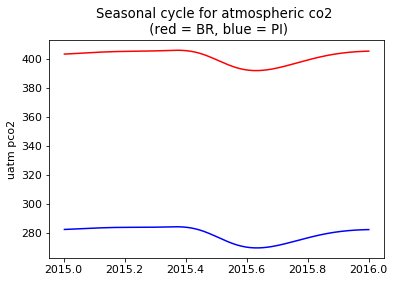

In [53]:
LR_slope   =  0     #!  linear regression + gaussian fit
LR_int     =  280 #!  to seasonal cycle of atmospheric co2
ctr        =  161.898  # !  based on scripps observations at ptbarrow and lajolla
amp        =  7.083  # !  calc notebook by TJSJ
wid        =  44.703  #  !  notebook loc:
ctr2       =  218.832  # !  carbon_dev/MOCSY_and_FLUX/CO2_obs.ipynb
amp2       =  -19.004   #!
wid2       =  87.8836   #!
ctr3       =  199.430   #!
amp3       =  8.026     #!
wid3       =  -185.920  #!
    

zz_LRslop = LR_slope
zz_LRint = LR_int
zz_ctr = ctr
zz_ctr2 = ctr2
zz_ctr3 = ctr3
zz_wid = wid
zz_wid2 = wid2
zz_wid3 = wid3
zz_amp = amp
zz_amp2 = amp2
zz_amp3 = amp3

atcco2_array_PI = np.zeros(365)

for i in range(0,len(arrow_array)):

    tdate = arrow_array[i][0]
    ymd = tdate.format('YYYYMMDD')
    doy = tdate.format('DDDD')
    yr = tdate.format('YYYY')
    
    zz_year = int(yr)
    zz_day = int(doy)

    zz_yearcyc =  zz_amp * np.exp( -((zz_day - zz_ctr)/zz_wid)**2)\
      + zz_amp2 * np.exp( -((zz_day - zz_ctr2)/zz_wid2)**2)\
      + zz_amp3 * np.exp( -((zz_day - zz_ctr3)/zz_wid3)**2)

    zz_atcco2 = (zz_year+(zz_day/365))*zz_LRslop+zz_LRint + zz_yearcyc
    atcco2_array_PI[i] = zz_atcco2
    dec_time_array[i] = zz_year+(zz_day/365)

plt.plot(dec_time_array,atcco2_array, 'r-')
plt.plot(dec_time_array,atcco2_array_PI, 'b-')
plt.title('Seasonal cycle for atmospheric co2 \n (red = BR, blue = PI)')
plt.ylabel('uatm pco2')

# air-sea flux

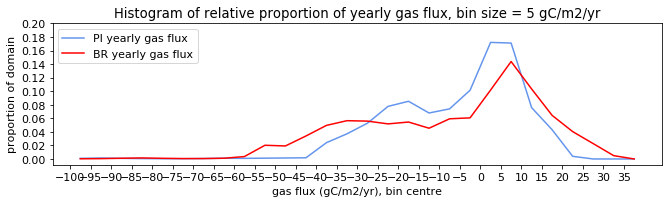

In [31]:


#LA_nonan = LA_flx_gC_m2_yr[~np.isnan(LA_flx_gC_m2_yr)]
BR_nonan = BR_flx_gC_m2_yr[~np.isnan(BR_flx_gC_m2_yr)]
PI_nonan = PI_flx_gC_m2_yr[~np.isnan(PI_flx_gC_m2_yr)]

step = 5
t_start = -100
t_end = 40
bin_starts = np.arange(t_start,t_end,step)
bin_ends = np.arange(t_start+step,t_end+step,step)
bin_centres = np.arange(t_start+step/2,t_end + step/2 ,step)
bin_prop = np.zeros_like(bin_centres)

def manual_hist(test_hist):
    for i in range(0,len(bin_starts)):
        obs_in_bin = test_hist[((test_hist>=bin_starts[i]) &\
                               (test_hist<bin_ends[i]))]

        bin_prop[i] = np.size(obs_in_bin)/np.size(test_hist)
    return bin_prop

# bin_propLA = manual_hist(LA_nonan)
# t_LA = np.copy(bin_propLA)
bin_propBR = manual_hist(BR_nonan)
t_BR = np.copy(bin_propBR)
bin_propPI = manual_hist(PI_nonan)   
t_PI = np.copy(bin_propPI)

fact = 0.52
fig = plt.figure(figsize=(21*fact,5*fact))
lw = 2.5
ax1 = fig.add_subplot(1,1,1)
#ax1.plot(bin_centres,t_LA, color = 'dimgrey', label = 'LA yearly gas flux')
ax1.plot(bin_centres,t_PI, color = 'cornflowerblue', label = 'PI yearly gas flux')
ax1.plot(bin_centres,t_BR, color = 'red', label = 'BR yearly gas flux')

ax1.legend(loc = 'upper left')
ax1.set_title('Histogram of relative proportion of yearly gas flux, bin size = 5 gC/m2/yr')

w = ax1.set_xticks(np.arange(-100, 40, step=5))
w = ax1.set_yticks(np.arange(0, 0.22, step=0.02))
ax1.set_xlabel('gas flux (gC/m2/yr), bin centre')
ax1.set_ylabel('proportion of domain')

data = pd.read_csv('../pkls/Evans_seaair_numbers.csv')
data = data.drop("Unnamed: 4",axis = 1)
data = data.drop("Unnamed: 5",axis = 1)
data = data.drop("Unnamed: 6",axis = 1)
data = data.drop([12,13,14,15,16,17,18,19,20], axis = 0)
data = (-1)*data

NS_W_mean = (1)*data['NSTRAIT_4'][0]; NS_W_std = (1)*data['NSTRAIT_4'][1] ;
NS_W_min = (1)*data['NSTRAIT_4'][2]; NS_W_max = (1)*data['NSTRAIT_4'][3] ; 
NS_S_mean = (1)*data['NSTRAIT_4'][4]; NS_S_std = (1)*data['NSTRAIT_4'][5] ;
NS_S_min = (1)*data['NSTRAIT_4'][6]; NS_S_max = (1)*data['NSTRAIT_4'][7] ;
NS_A_mean = (1)*data['NSTRAIT_4'][8]; NS_A_std = (1)*data['NSTRAIT_4'][9] ;
NS_A_min = (1)*data['NSTRAIT_4'][10]; NS_A_max = (1)*data['NSTRAIT_4'][11] ;

CS_W_mean = (1)*data['CSTRAIT_5'][0]; CS_W_std = (1)*data['CSTRAIT_5'][1] ;
CS_W_min = (1)*data['CSTRAIT_5'][2]; CS_W_max = (1)*data['CSTRAIT_5'][3] ; 
CS_S_mean = (1)*data['CSTRAIT_5'][4]; CS_S_std = (1)*data['CSTRAIT_5'][5] ;
CS_S_min = (1)*data['CSTRAIT_5'][6]; CS_S_max = (1)*data['CSTRAIT_5'][7] ;
CS_A_mean = (1)*data['CSTRAIT_5'][8]; CS_A_std = (1)*data['CSTRAIT_5'][9] ;
CS_A_min = (1)*data['CSTRAIT_5'][10]; CS_A_max = (1)*data['CSTRAIT_5'][11] ;

JDF_W_mean = (1)*data['JDF_6'][0]; JDF_W_std = (1)*data['JDF_6'][1] ;
JDF_W_min = (1)*data['JDF_6'][2]; JDF_W_max = (1)*data['JDF_6'][3] ; 
JDF_S_mean = (1)*data['JDF_6'][4]; JDF_S_std = (1)*data['JDF_6'][5] ;
JDF_S_min = (1)*data['JDF_6'][6]; JDF_S_max = (1)*data['JDF_6'][7] ;
JDF_A_mean = (1)*data['JDF_6'][8]; JDF_A_std = (1)*data['JDF_6'][9] ;
JDF_A_min = (1)*data['JDF_6'][10]; JDF_A_max = (1)*data['JDF_6'][11] ;



In [32]:
#extract (1)*data manually and switch sign
NS_W_mean = (1)*data['NSTRAIT_4'][0]; NS_W_std = (1)*data['NSTRAIT_4'][1] ;
NS_W_min = (1)*data['NSTRAIT_4'][2]; NS_W_max = (1)*data['NSTRAIT_4'][3] ; 
NS_S_mean = (1)*data['NSTRAIT_4'][4]; NS_S_std = (1)*data['NSTRAIT_4'][5] ;
NS_S_min = (1)*data['NSTRAIT_4'][6]; NS_S_max = (1)*data['NSTRAIT_4'][7] ;
NS_A_mean = (1)*data['NSTRAIT_4'][8]; NS_A_std = (1)*data['NSTRAIT_4'][9] ;
NS_A_min = (1)*data['NSTRAIT_4'][10]; NS_A_max = (1)*data['NSTRAIT_4'][11] ;

CS_W_mean = (1)*data['CSTRAIT_5'][0]; CS_W_std = (1)*data['CSTRAIT_5'][1] ;
CS_W_min = (1)*data['CSTRAIT_5'][2]; CS_W_max = (1)*data['CSTRAIT_5'][3] ; 
CS_S_mean = (1)*data['CSTRAIT_5'][4]; CS_S_std = (1)*data['CSTRAIT_5'][5] ;
CS_S_min = (1)*data['CSTRAIT_5'][6]; CS_S_max = (1)*data['CSTRAIT_5'][7] ;
CS_A_mean = (1)*data['CSTRAIT_5'][8]; CS_A_std = (1)*data['CSTRAIT_5'][9] ;
CS_A_min = (1)*data['CSTRAIT_5'][10]; CS_A_max = (1)*data['CSTRAIT_5'][11] ;

JDF_W_mean = (1)*data['JDF_6'][0]; JDF_W_std = (1)*data['JDF_6'][1] ;
JDF_W_min = (1)*data['JDF_6'][2]; JDF_W_max = (1)*data['JDF_6'][3] ; 
JDF_S_mean = (1)*data['JDF_6'][4]; JDF_S_std = (1)*data['JDF_6'][5] ;
JDF_S_min = (1)*data['JDF_6'][6]; JDF_S_max = (1)*data['JDF_6'][7] ;
JDF_A_mean = (1)*data['JDF_6'][8]; JDF_A_std = (1)*data['JDF_6'][9] ;
JDF_A_min = (1)*data['JDF_6'][10]; JDF_A_max = (1)*data['JDF_6'][11] ;

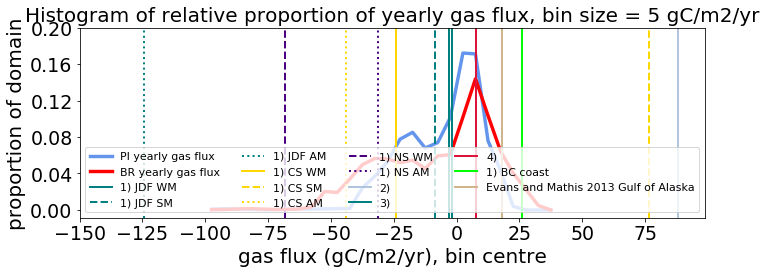

In [54]:
corfact = 1/(1 * (1/365) * (1 / 12.0107e-3))

fact = 0.7
fig = plt.figure(figsize=(16*fact,5*fact))
lw = 2.5
ax1 = fig.add_subplot(1,1,1)
#ax1.plot(bin_centres,t_LA, color = 'dimgrey', lw = 3.4, label = 'LA yearly gas flux')
ax1.plot(bin_centres,t_PI, color = 'cornflowerblue', lw = 3.4,label = 'PI yearly gas flux')
ax1.plot(bin_centres,t_BR, color = 'red', lw = 3.4,label = 'BR yearly gas flux')

ax1.axvline(JDF_W_mean*corfact, color = 'teal', lw = 2, label = '1) JDF WM')
ax1.axvline(JDF_S_mean*corfact, color = 'teal', linestyle = '--' , lw = 2, label = '1) JDF SM')
ax1.axvline(JDF_A_mean*corfact, color = 'teal', linestyle = ':', lw = 2, label = '1) JDF AM')

ax1.axvline(CS_W_mean*corfact, color = 'gold', lw = 2, label = '1) CS WM')
ax1.axvline(CS_S_mean*corfact, color = 'gold', linestyle = '--' , lw = 2, label = '1) CS SM')
ax1.axvline(CS_A_mean*corfact, color = 'gold', linestyle = ':', lw = 2, label = '1) CS AM')

#ax1.axvline(NS_W_mean*corfact, color = 'indigo', lw = 2, label = 'NS winter mean')
ax1.axvline(NS_S_mean*corfact, color = 'indigo', linestyle = '--' , lw = 2, label = '1) NS WM')
ax1.axvline(NS_A_mean*corfact, color = 'indigo', linestyle = ':', lw = 2, label = '1) NS AM')

#
ax1.axvline(88, color = 'lightsteelblue', lw = 2, label = '2)')
ax1.axvline(-3.1, color = 'teal', lw = 2, label = '3)')
ax1.axvline(7.9, color = 'crimson', lw = 2, label = '4)')
ax1.axvline(26, color = 'lime', lw = 2, label = '1) BC coast')
ax1.axvline(18, color = 'tan', lw = 2, label = 'Evans and Mathis 2013 Gulf of Alaska')

ax1.legend(loc="lower right",ncol=4)
ax1.set_title('Histogram of relative proportion of yearly gas flux, bin size = 5 gC/m2/yr', fontsize =20)

w = ax1.set_xticks(np.arange(-150, 100, step=25))
w = ax1.set_yticks(np.arange(0, 0.22, step=0.04))
ax1.set_xlabel('gas flux (gC/m2/yr), bin centre', fontsize =20 )
ax1.set_ylabel('proportion of domain', fontsize =20)
ax1.tick_params(axis='both', which='major', labelsize=19)
ax1.tick_params(axis='both', which='minor', labelsize=19)


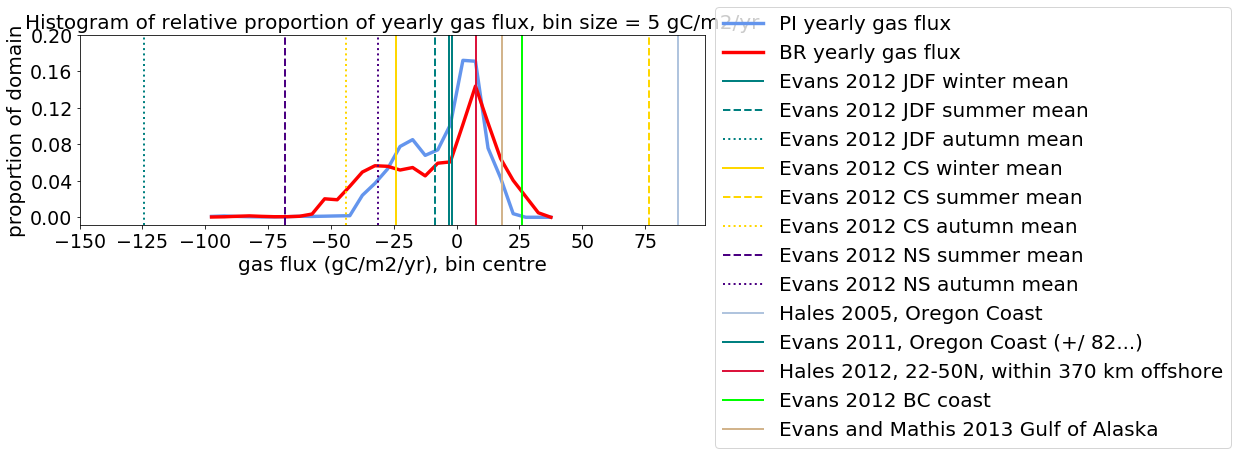

In [34]:
corfact = 1/(1 * (1/365) * (1 / 12.0107e-3))

fact = 0.7
fig = plt.figure(figsize=(16*fact,5*fact))
lw = 2.5
ax1 = fig.add_subplot(1,1,1)
#ax1.plot(bin_centres,t_LA, color = 'dimgrey', lw = 3.4, label = 'LA yearly gas flux')
ax1.plot(bin_centres,t_PI, color = 'cornflowerblue', lw = 3.4,label = 'PI yearly gas flux')
ax1.plot(bin_centres,t_BR, color = 'red', lw = 3.4,label = 'BR yearly gas flux')

ax1.axvline(JDF_W_mean*corfact, color = 'teal', lw = 2, label = 'Evans 2012 JDF winter mean')
ax1.axvline(JDF_S_mean*corfact, color = 'teal', linestyle = '--' , lw = 2, label = 'Evans 2012 JDF summer mean')
ax1.axvline(JDF_A_mean*corfact, color = 'teal', linestyle = ':', lw = 2, label = 'Evans 2012 JDF autumn mean')

ax1.axvline(CS_W_mean*corfact, color = 'gold', lw = 2, label = 'Evans 2012 CS winter mean')
ax1.axvline(CS_S_mean*corfact, color = 'gold', linestyle = '--' , lw = 2, label = 'Evans 2012 CS summer mean')
ax1.axvline(CS_A_mean*corfact, color = 'gold', linestyle = ':', lw = 2, label = 'Evans 2012 CS autumn mean')

#ax1.axvline(NS_W_mean*corfact, color = 'indigo', lw = 2, label = 'NS winter mean')
ax1.axvline(NS_S_mean*corfact, color = 'indigo', linestyle = '--' , lw = 2, label = 'Evans 2012 NS summer mean')
ax1.axvline(NS_A_mean*corfact, color = 'indigo', linestyle = ':', lw = 2, label = 'Evans 2012 NS autumn mean')

#
ax1.axvline(88, color = 'lightsteelblue', lw = 2, label = 'Hales 2005, Oregon Coast')
ax1.axvline(-3.1, color = 'teal', lw = 2, label = 'Evans 2011, Oregon Coast (+/ 82...)')
ax1.axvline(7.9, color = 'crimson', lw = 2, label = 'Hales 2012, 22-50N, within 370 km offshore')
ax1.axvline(26, color = 'lime', lw = 2, label = 'Evans 2012 BC coast')
ax1.axvline(18, color = 'tan', lw = 2, label = 'Evans and Mathis 2013 Gulf of Alaska')

ax1.legend(bbox_to_anchor=[1.00, 1.2], fontsize =20)
ax1.set_title('Histogram of relative proportion of yearly gas flux, bin size = 5 gC/m2/yr', fontsize =20)

w = ax1.set_xticks(np.arange(-150, 100, step=25))
w = ax1.set_yticks(np.arange(0, 0.22, step=0.04))
ax1.set_xlabel('gas flux (gC/m2/yr), bin centre', fontsize =20 )
ax1.set_ylabel('proportion of domain', fontsize =20)
ax1.tick_params(axis='both', which='major', labelsize=19)
ax1.tick_params(axis='both', which='minor', labelsize=19)

# nice plot

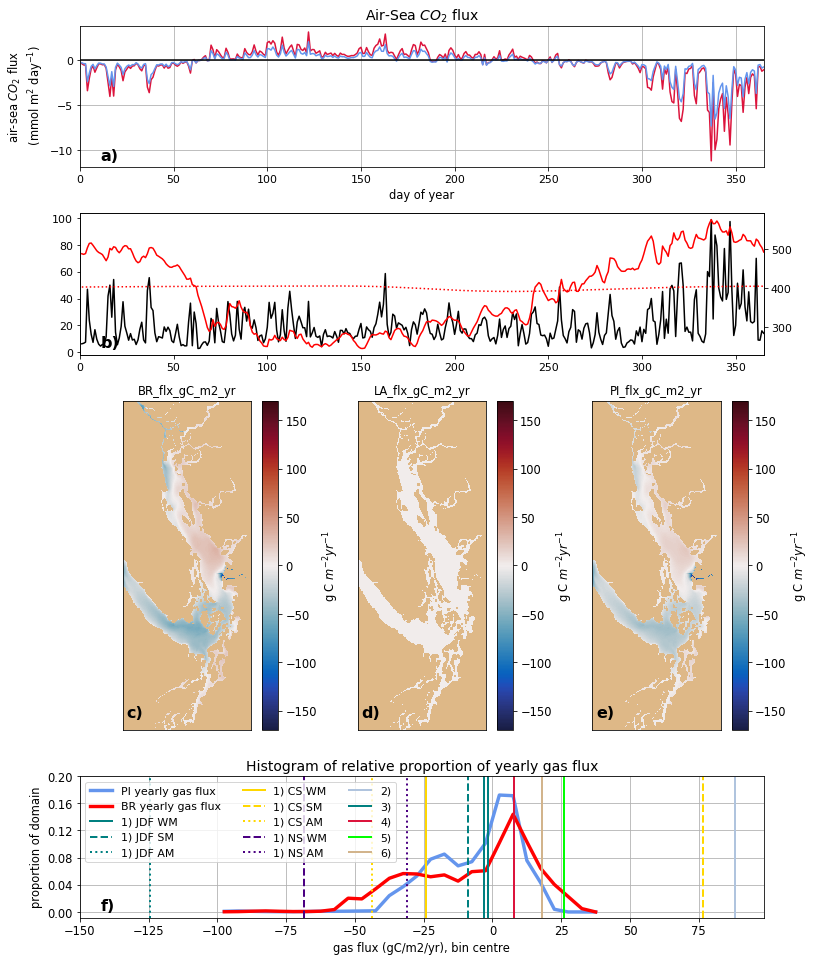

In [36]:
dic_min = 1900
dic_max = 2300
dicstep = 10
days = np.arange(1,366,1)
fact = 1.0
fs = 11.5
ts = 14
mlt = 1

fig = plt.figure(figsize=(11.5*fact, 13.5*fact))

ax1 = plt.subplot2grid((5,3), (0,0), colspan=3, rowspan=1) # topleft
ax1.plot(days,BR_daily_mean_mmol_m2_day,color = 'crimson',label = 'BR3 run')
#ax1.plot(days,LA_daily_mean_mmol_m2_day,color = 'slategrey',label = 'LA run')
ax1.plot(days,PI_daily_mean_mmol_m2_day,color = 'cornflowerblue',label = 'PI4 run')
ax1.set_xlabel('day of year',fontsize = fs)
ax1.set_ylabel('air-sea $CO_2$ flux \n (mmol m$^{2}$ day$^{-1}$)', fontsize = fs)
ax1.set_title('Air-Sea $CO_2$ flux', fontsize = ts)

ax1.set_xlim([0,365])
ax1.grid()
ax1.axhline(y=0, color = 'k')
ax1.text(0.03, 0.03, 'a)', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='bottom')


ax2 = plt.subplot2grid((5,3), (1,0), colspan=3) 
ax2b =ax2.twinx()
ax2.plot(days,wind_daily_mean_squared,'-k', label = 'wind speed')

ax2b.plot(days,pco2_daily_mean_BR3,'-r', label = 'seawater pCO$_2$')
ax2b.plot(days,atcco2_array,color = 'r', linestyle = ':', label = 'atmospheric pCO$_2$' )

# ax2b.axhline(y=409, color = 'r', linestyle = ':')

ax2.set_xlim([0,365])
ax2b.set_xlim([0,365])
ax2.text(0.03, 0.03, 'b)', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='bottom')


ax3 = plt.subplot2grid((5,3), (2,0), colspan=1,rowspan = 2)
tplt = BR_flx_gC_m2_yr
viz_tools.set_aspect(ax3)
mesh = ax3.pcolormesh(tplt, cmap=cm.balance, vmin=-170, vmax=170)
viz_tools.plot_land_mask(ax3, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc', color = 'burlywood')
ax3.set_title('BR_flx_gC_m2_yr', fontsize = fs)
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(mesh)
cbar.ax.tick_params(labelsize=fs)
cbar.set_label('g C $m^{-2}$$yr^{-1}$', fontsize = fs)
ax3.text(0.03, 0.03, 'c)', transform=ax3.transAxes, fontsize=16, fontweight='bold', va='bottom')


ax4 = plt.subplot2grid((5,3), (2,1), colspan=1,rowspan = 2)
#tplt = LA_flx_gC_m2_yr
zeromask = np.zeros([898,398])
viz_tools.set_aspect(ax4)
mesh = ax4.pcolormesh(zeromask, cmap=cm.balance, vmin=-170, vmax=170)
viz_tools.plot_land_mask(ax4, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc', color = 'burlywood')
ax4.set_title('LA_flx_gC_m2_yr', fontsize = fs)
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(mesh)
cbar.ax.tick_params(labelsize=fs)
cbar.set_label('g C $m^{-2}$$yr^{-1}$', fontsize = fs)
ax4.text(0.03, 0.03, 'd)', transform=ax4.transAxes, fontsize=16, fontweight='bold', va='bottom')


ax5 = plt.subplot2grid((5,3), (2,2), colspan=1,rowspan = 2)
tplt = PI_flx_gC_m2_yr
viz_tools.set_aspect(ax5)
mesh = ax5.pcolormesh(tplt, cmap=cm.balance, vmin=-170, vmax=170)
viz_tools.plot_land_mask(ax5, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc', color = 'burlywood')
ax5.set_title('PI_flx_gC_m2_yr', fontsize = fs)
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(mesh)
cbar.ax.tick_params(labelsize=fs)
cbar.set_label('g C $m^{-2}$$yr^{-1}$', fontsize = fs)
ax5.text(0.03, 0.03, 'e)', transform=ax5.transAxes, fontsize=16, fontweight='bold', va='bottom')




ax6 = plt.subplot2grid((5,3),(4,0), colspan=3)
ax6.text(0.03, 0.03, 'f)', transform=ax6.transAxes, fontsize=16, fontweight='bold', va='bottom')
corfact = 1/(1 * (1/365) * (1 / 12.0107e-3))
lw = 2.5

#ax6.plot(bin_centres,t_LA, color = 'dimgrey', lw = 3.4, label = 'LA yearly gas flux')
ax6.plot(bin_centres,t_PI, color = 'cornflowerblue', lw = 3.4,label = 'PI yearly gas flux')
ax6.plot(bin_centres,t_BR, color = 'red', lw = 3.4,label = 'BR yearly gas flux')

ax6.axvline(JDF_W_mean*corfact, color = 'teal', lw = 2, label = '1) JDF WM')
ax6.axvline(JDF_S_mean*corfact, color = 'teal', linestyle = '--' , lw = 2, label = '1) JDF SM')
ax6.axvline(JDF_A_mean*corfact, color = 'teal', linestyle = ':', lw = 2, label = '1) JDF AM')

ax6.axvline(CS_W_mean*corfact, color = 'gold', lw = 2, label = '1) CS WM')
ax6.axvline(CS_S_mean*corfact, color = 'gold', linestyle = '--' , lw = 2, label = '1) CS SM')
ax6.axvline(CS_A_mean*corfact, color = 'gold', linestyle = ':', lw = 2, label = '1) CS AM')

#ax6.axvline(NS_W_mean*corfact, color = 'indigo', lw = 2, label = 'NS winter mean')
ax6.axvline(NS_S_mean*corfact, color = 'indigo', linestyle = '--' , lw = 2, label = '1) NS WM')
ax6.axvline(NS_A_mean*corfact, color = 'indigo', linestyle = ':', lw = 2, label = '1) NS AM')

#
ax6.axvline(88, color = 'lightsteelblue', lw = 2, label = '2)')
ax6.axvline(-3.1, color = 'teal', lw = 2, label = '3)')
ax6.axvline(7.9, color = 'crimson', lw = 2, label = '4)')
ax6.axvline(26, color = 'lime', lw = 2, label = '5)')
ax6.axvline(18, color = 'tan', lw = 2, label = '6)')

ax6.legend(loc="upper left",ncol=3)
ax6.set_title('Histogram of relative proportion of yearly gas flux', fontsize =ts)

w = ax6.set_xticks(np.arange(-150, 100, step=25))
w = ax6.set_yticks(np.arange(0, 0.22, step=0.04))
ax6.set_xlabel('gas flux (gC/m2/yr), bin centre', fontsize = fs)
ax6.set_ylabel('proportion of domain', fontsize =fs)
ax6.tick_params(axis='both', which='major', labelsize=fs)
ax6.tick_params(axis='both', which='minor', labelsize=fs)
ax6.grid()

fig.tight_layout()

In [38]:
winds_janfeb = (wind_daily_mean_squared[0:59])
winds_dec = (wind_daily_mean_squared[335:365])
#wind_wint = np.concatenate(winds_janfeb,winds_dec)

windwint2 = np.zeros(120)
windwint2[0:59] = winds_janfeb
windwint2[60:90] = winds_dec
windwint2[windwint2 == 0] = np.nan
print(np.nanmean(windwint2))

summerwind = wind_daily_mean_squared[151:243]
print(np.mean(summerwind))

25.697493869267152
18.984247306118842


In [43]:
pco2s_janfeb = (pco2_daily_mean_BR3[0:59])
pco2s_dec = (pco2_daily_mean_BR3[335:365])

pco2wint2 = np.zeros(120)
pco2wint2[0:59] = pco2s_janfeb
pco2wint2[60:90] = pco2s_dec
pco2wint2[pco2wint2 == 0] = np.nan
print('winter pco2-BR')
print(np.nanmean(pco2wint2))

summerpco2 = pco2_daily_mean_BR3[151:243]
print('summer pco2-BR')
print(np.mean(summerpco2))

print('***')
pco2s_janfeb = (pco2_daily_mean_PI4[0:59])
pco2s_dec = (pco2_daily_mean_PI4[335:365])

pco2wint2 = np.zeros(120)
pco2wint2[0:59] = pco2s_janfeb
pco2wint2[60:90] = pco2s_dec
pco2wint2[pco2wint2 == 0] = np.nan
print('winter pco2-PI')
print(np.nanmean(pco2wint2))

summerpco2 = pco2_daily_mean_PI4[151:243]
print('summer pco2-PI')
print(np.mean(summerpco2))

winter pco2-BR
499.29881715238764
summer pco2-BR
307.5424759906271
***
winter pco2-PI
351.1126983299684
summer pco2-PI
228.50228069139564
